In [116]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
from shapely import wkt
from shapely.ops import cascaded_union

from datetime import datetime, timedelta

## 数据导入和可视化

In [10]:
# 导入数据
path = 'D:/317研究组/4 居住自选择/data/relocation_sample_stay.csv'
stay = pd.read_csv(path)

stay['stime'] = pd.to_datetime(stay['stime'],format='%Y-%m-%d %H:%M:%S')
stay['etime'] = pd.to_datetime(stay['etime'],format='%Y-%m-%d %H:%M:%S')

# 增加一列指示月份
stay['yearmonth'] = np.floor(stay['date']/100)*100+1

# 改名
stay.rename(columns={'chinese':'lambda','math':'phi'},inplace=True)
stay['lambda'] = stay['lambda']*10-5
stay['phi'] = stay['phi']*10-5

stay.head()

,who,date,stime,etime,poi_id,lambda,phi,yearmonth
0,509,20191228,2019-12-28 08:09:56,2019-12-28 08:40:22,11,114.113935,22.606130,20191201.0
1,509,20200502,2020-05-02 16:05:32,2020-05-02 16:54:03,8,114.081120,22.544308,20200501.0
2,509,20190817,2019-08-17 00:02:56,2019-08-17 08:07:10,2,113.891201,22.586069,20190801.0
3,509,20190828,2019-08-28 05:40:55,2019-08-28 08:35:05,2,113.891201,22.586069,20190801.0
4,509,20190801,2019-08-01 19:20:31,2019-08-01 19:20:31,2,113.891201,22.586069,20190801.0


In [175]:
print(stay['who'].unique())

[ 509 1731 1678 4771 2773 2434 3861 2078 3743 1315]


In [226]:
# 选择who=2078为样本（仅需要2019年的数据）进行分析
sample_stay = stay[(stay['who']==2078) & (stay['yearmonth'].between(20190101,20191201))]

#按照year_month和poi_id分组，统计每个poi_id出现的次数
sample_stay_count =sample_stay.groupby(['who','yearmonth','poi_id']).agg(stay_count=('poi_id','count'),
                                                                  mean_lambda=('lambda','mean'),
                                                                  mean_phi=('phi','mean')).reset_index()
sample_stay_count.head()

,who,yearmonth,poi_id,stay_count,mean_lambda,mean_phi
0,2078,20190101.0,0,15,113.877359,22.564647
1,2078,20190101.0,1,2,113.864621,22.573622
2,2078,20190101.0,2,1,114.006432,22.674125
3,2078,20190201.0,0,17,113.875890,22.568598
4,2078,20190201.0,1,2,113.917753,22.546259


In [227]:
# 构建gpd对象
poi_geometry = [Point(xy) for xy in zip(sample_stay_count['mean_lambda'],sample_stay_count['mean_phi'])]
crs = {'init':'epsg:4326'}
sample_stay_gpd = gpd.GeoDataFrame(sample_stay_count,crs=crs,geometry=poi_geometry)

C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [224]:
# 以样本2078为demo，导入家数据
path1 ='D:/317研究组/4 居住自选择/data/sample_data/who2078_home.csv'
sample_home = pd.read_csv(path1)

city_grid = pd.read_csv('D:/317研究组/4 居住自选择/data/ss_city_grid/grid/ss_city_grid_by_cover.csv')
sample_home  = pd.merge(sample_home,city_grid[['fnid','wkt']],on='fnid',how='left')

# 转化为gpd对象
sample_home['wkt'] = sample_home['wkt'].apply(wkt.loads)
city_grid['wkt'] = city_grid['wkt'].apply(wkt.loads)
sample_home['wkt_centroid'] = [x.centroid for x in sample_home['wkt']]
crs = {'init':'epsg:4326'}
sample_home_gpd = gpd.GeoDataFrame(sample_home,crs=crs,geometry=sample_home.wkt_centroid)

sample_home.head()

C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pandas\core\dtypes\cast.py:128: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pandas\core\dtypes\inference.py:391: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geo

,who,date,fnid,chess_x,chess_y,home_fre,home_time,od_num,max_fre,max_time,group_id,avg_fre,wkt,wkt_centroid
0,2078,20181101,18617,53,52,7,355343,34,7,355343,0,5.750000,"(POLYGON ((113.87849748 22.56262979, 113.88093...",POINT (113.87971765 22.563737765)
1,2078,20190101,18616,52,52,6,213718,27,6,213718,0,5.750000,"(POLYGON ((113.87605714 22.56262979, 113.87849...",POINT (113.87727730999998 22.563737765)
2,2078,20190201,19329,51,54,4,137587,26,4,137587,0,5.750000,"(POLYGON ((113.87361681 22.5670617, 113.876057...",POINT (113.87483697499998 22.568169680000004)
3,2078,20190301,19329,51,54,6,149011,34,6,149011,0,5.750000,"(POLYGON ((113.87361681 22.5670617, 113.876057...",POINT (113.87483697499998 22.568169680000004)
4,2078,20190401,30467,122,85,14,231828,20,14,231828,1,27.444444,"(POLYGON ((114.04688067 22.63575638, 114.04932...",POINT (114.04810084 22.63686436)


<Axes: >

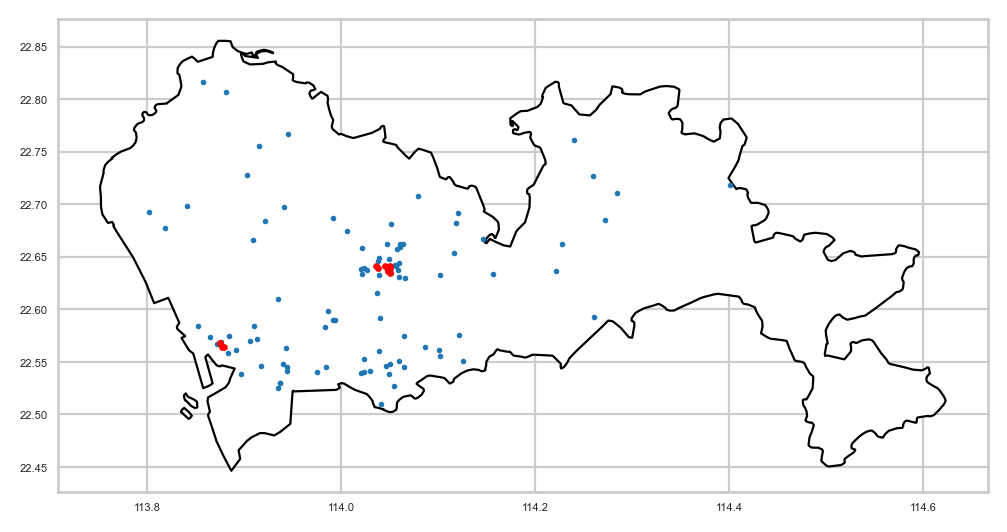

In [228]:
# 活动地可视化
# 导入深圳地图
file_name ="D:/317研究组/4 居住自选择/data/shenzhen_polygon/Shenzhen_polygon.shp"
sz_poly = gpd.read_file(file_name)

# 可视化活动点和居住地
fig,ax = plt.subplots(dpi=200)
sz_poly.plot(ax=ax,fc='white',ec='black',linewidth=.8)
sample_stay_gpd.plot(ax=ax,markersize=1)
sample_home_gpd.plot(ax=ax, c='red', markersize=2)

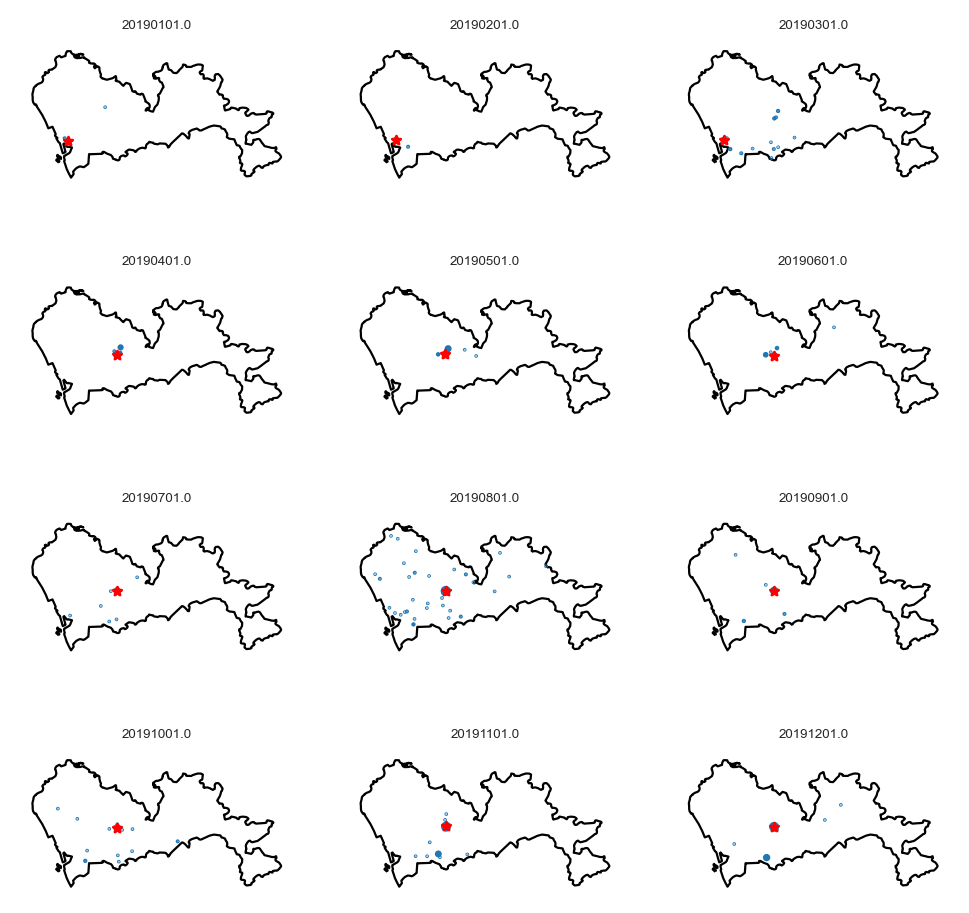

In [229]:
# 以分图的形式绘制每个月的活动点
m = 4; n=3 #定义子图的行数和列数
fig,ax = plt.subplots(m,n,figsize= (6,6), dpi=200)
# 设置较小的字体
plt.rcParams.update({'font.size': 4})
date_index =sample_stay_gpd['yearmonth'].unique()
date_index.sort()
for i in range(m):
    for j in range(n):
        t = i*n+j
        ax[i,j].set_title(str(date_index[t]))
        stay_data = sample_stay_gpd[sample_stay_gpd['yearmonth']==date_index[t]]
        home_data = sample_home_gpd[sample_home_gpd['date']==date_index[t]]
        sz_poly.plot(ax=ax[i,j],fc='white',ec='black',linewidth=.8)
        # 画出stay_data，点的大小由stay_count决定
        stay_data.plot(ax=ax[i,j], markersize=stay_data['stay_count']/10)
        # 设置坐标轴不可见
        ax[i,j].set_axis_off()
        home_data.plot(ax=ax[i,j], c='red', marker='*', markersize=10)
    #ax.set_xlim(bounds[0],bounds[2])
    #ax.set_ylim(bounds[1],bounds[3])
plt.show()

## 变量准备

### 建成环境变量

In [230]:
path2 = "D:/317研究组/4 居住自选择/data/BE_varis.csv"
be_varies = pd.read_csv(path2)
be_varies.head()

,fnid,row,column,density,landusemix,openratio_wide,intersections,road_density,center,airport,...,dock,coach,eat,shop,hosp,subway,bus,edu,married,rent
0,413,186,56,0.0,0.0,0.000000,0.0,0.0,11.455655,23.670858,...,0.021979,0.021979,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.28075
1,665,186,308,0.0,0.0,0.591606,0.0,0.0,40.357446,98.554691,...,84.886209,20.731583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.26000
2,666,186,309,0.0,0.0,0.641593,0.0,0.0,40.358706,98.555951,...,84.887469,20.732843,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.26000
3,667,186,310,0.0,0.0,0.629622,0.0,0.0,40.360758,98.558002,...,84.889520,20.734894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.26000
4,668,186,311,0.0,0.0,0.623242,0.0,0.0,40.362370,98.559615,...,84.891133,20.736507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.26000


In [231]:
# 根据fnid一列左关联sample_home和be_varies
sample_home = pd.merge(sample_home,be_varies[['fnid','density','landusemix','intersections','center','subway','bus']],on='fnid',how='left')
sample_home.head()

C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pandas\core\dtypes\inference.py:391: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pandas\core\dtypes\inference.py:392: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pandas\io\formats\printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(

,who,date,fnid,chess_x,chess_y,home_fre,home_time,od_num,max_fre,max_time,group_id,avg_fre,wkt,wkt_centroid,density,landusemix,intersections,center,subway,bus
0,2078,20181101,18617,53,52,7,355343,34,7,355343,0,5.750000,"(POLYGON ((113.87849748 22.56262979, 113.88093...",POINT (113.87971765 22.563737765),11.372603,0.687790,32.000000,0.000000,0.000000,10.666667
1,2078,20190101,18616,52,52,6,213718,27,6,213718,0,5.750000,"(POLYGON ((113.87605714 22.56262979, 113.87849...",POINT (113.87727730999998 22.563737765),15.337164,0.745596,49.777778,0.000000,1.777778,7.111111
2,2078,20190201,19329,51,54,4,137587,26,4,137587,0,5.750000,"(POLYGON ((113.87361681 22.5670617, 113.876057...",POINT (113.87483697499998 22.568169680000004),45.367300,0.691484,44.444444,0.000000,0.000000,12.444444
3,2078,20190301,19329,51,54,6,149011,34,6,149011,0,5.750000,"(POLYGON ((113.87361681 22.5670617, 113.876057...",POINT (113.87483697499998 22.568169680000004),45.367300,0.691484,44.444444,0.000000,0.000000,12.444444
4,2078,20190401,30467,122,85,14,231828,20,14,231828,1,27.444444,"(POLYGON ((114.04688067 22.63575638, 114.04932...",POINT (114.04810084 22.63686436),28.201046,0.643552,39.111111,5.293008,0.000000,7.111111


In [232]:
# 根据group_id对建成环境指标做平均
sample_home_be = sample_home.groupby('group_id').agg(density=('density','mean'),
                                                        landusemix=('landusemix','mean'),
                                                        intersections=('intersections','mean'),
                                                        center=('center','mean'),
                                                        subway=('subway','mean'),
                                                        bus=('bus','mean'),
                                                     area =('wkt',lambda x:cascaded_union(x))).reset_index()
# 删除groupid=noise的行
sample_home_be = sample_home_be[sample_home_be['group_id']!='NOISE']
sample_home_be

C:\Users\huangnx\AppData\Local\Temp\ipykernel_27780\1951401210.py:8: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  area =('wkt',lambda x:cascaded_union(x))).reset_index()
C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pandas\core\dtypes\inference.py:391: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pandas\core\dtypes\inference.py:392: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pandas\io\for

,group_id,density,landusemix,intersections,center,subway,bus,area
0,0,29.361092,0.704089,42.666667,0.000000,0.444444,10.666667,"(POLYGON ((113.87605714 22.56484574, 113.87849..."
1,1,32.936153,0.637692,29.827160,5.349835,0.000000,4.148148,"(POLYGON ((114.04932101 22.63354043, 114.04932..."
2,2,49.885149,0.733171,27.851852,4.890331,0.000000,7.703704,"(POLYGON ((114.03955966 22.6401883, 114.039559..."


### 出行行为变量

In [233]:
# 获取居住地位置
# 根据sample_stay_gpd中的point和city_grid的wkt的包含关系，为每个poi_id赋fnid
city_grid_gpd = gpd.GeoDataFrame(city_grid,crs=crs,geometry=city_grid.wkt)
sample_stay_gpd = gpd.sjoin(sample_stay_gpd,city_grid_gpd,how='left',op='within')
# sample_stay_gpd

# 根据fnid一列内关联sample_stay_gpd和sample_home
# 将sample_home的date改名为yearmonth
sample_home.rename(columns={'date':'yearmonth'},inplace=True)
sample_home_loc = pd.merge(sample_stay_gpd,sample_home[['yearmonth','fnid']],on=['yearmonth','fnid'],how='inner')

# 如果相同yearmonth下，有多个poi_id，则保留stay_count较大的一个
sample_home_loc = sample_home_loc.sort_values(by=['who','yearmonth','stay_count'],ascending=False).drop_duplicates(['who','yearmonth'])

C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3309: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [234]:
sample_home_loc.head()

C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pandas\core\dtypes\inference.py:391: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pandas\core\dtypes\inference.py:392: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pandas\io\formats\printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(

,who,yearmonth,poi_id,stay_count,mean_lambda,mean_phi,geometry,index_right,fnid,chess_x,chess_y,wkt
11,2078,20191201.0,0,66,114.050040,22.639951,POINT (114.05004 22.63995),13624,30825,123,86,"(POLYGON ((114.04932101 22.63797234, 114.05176..."
10,2078,20191101.0,1,68,114.050885,22.640427,POINT (114.05089 22.64043),13949,31182,123,87,"(POLYGON ((114.04932101 22.6401883, 114.051761..."
9,2078,20191001.0,0,33,114.049039,22.636304,POINT (114.04904 22.63630),13298,30467,122,85,"(POLYGON ((114.04688067 22.63575638, 114.04932..."
8,2078,20190901.0,0,41,114.050387,22.638795,POINT (114.05039 22.63879),13624,30825,123,86,"(POLYGON ((114.04932101 22.63797234, 114.05176..."
7,2078,20190801.0,0,72,114.049766,22.638305,POINT (114.04977 22.63830),13624,30825,123,86,"(POLYGON ((114.04932101 22.63797234, 114.05176..."


In [219]:
# 对旧家、新家的位置取加权平均，加入到sample_home_be中
# move_yearmonth为sample_home中第一个出现group_id=1的yearmonth
move_yearmonth = sample_home[sample_home['group_id']=='1']['date'].min()
# 在sample_home_loc中，将旧家、新家的位置分别取出
sample_home_loc_old = sample_home_loc[sample_home_loc['yearmonth']<move_yearmonth]
sample_home_loc_new = sample_home_loc[sample_home_loc['yearmonth']>=move_yearmonth]
# 对旧家、新家的位置取加权平均
old_mean_lambda = sum(sample_home_loc_old['mean_lambda']*sample_home_loc_old['stay_count'])/sum(sample_home_loc_old['stay_count'])
old_mean_phi = sum(sample_home_loc_old['mean_phi']*sample_home_loc_old['stay_count'])/sum(sample_home_loc_old['stay_count'])
new_mean_lambda = sum(sample_home_loc_new['mean_lambda']*sample_home_loc_new['stay_count'])/sum(sample_home_loc_new['stay_count'])
new_mean_phi = sum(sample_home_loc_new['mean_phi']*sample_home_loc_new['stay_count'])/sum(sample_home_loc_new['stay_count'])
# 将旧家、新家的位置加入到sample_home_be中
sample_home_be['mean_lambda'] = [old_mean_lambda, new_mean_lambda]
sample_home_be['mean_phi'] = [old_mean_phi, new_mean_phi]

In [220]:
sample_home_be

,group_id,density,landusemix,intersections,center,subway,bus,area,mean_lambda,mean_phi
0,0,48.160131,0.677681,22.518519,3.816949,0.0,5.333333,"POLYGON ((114.03467899 22.64905213, 114.032238...",114.032285,22.651287
1,1,48.638002,0.642514,15.703704,6.068051,0.0,11.456790,"POLYGON ((113.87605714 22.77979362, 113.873616...",113.876650,22.779416


In [185]:
# 按照stime排序sample_stay_gpd
sample_stay.sort_values(by=['who','stime'],inplace=True)
sample_stay.head()

C:\Users\huangnx\AppData\Local\Temp\ipykernel_27780\1299423695.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_stay.sort_values(by=['who','stime'],inplace=True)


,who,date,stime,etime,poi_id,lambda,phi,yearmonth
1798,1731,20190101,2019-01-01 11:44:06,2019-01-01 15:42:08,0,114.032822,22.651286,20190101.0
2668,1731,20190101,2019-01-01 15:43:17,2019-01-01 18:26:36,8,114.024762,22.626426,20190101.0
1838,1731,20190101,2019-01-01 18:29:24,2019-01-01 22:17:25,6,114.040411,22.645163,20190101.0
1816,1731,20190102,2019-01-02 03:02:07,2019-01-02 23:16:20,0,114.032822,22.651286,20190101.0
1810,1731,20190103,2019-01-03 00:15:26,2019-01-03 07:51:18,0,114.032822,22.651286,20190101.0


In [191]:
# 识别迁居点，新家第一次在夜间出现的时间

sample_stay['shour'] = sample_stay['stime'].apply(lambda x:x.hour)
sample_stay['ehour'] = sample_stay['etime'].apply(lambda x:x.hour)
# 获取夜间（ehour>=20）并且是当天最后一行的数据
sample_stay_night = sample_stay[sample_stay['ehour']>=20]
sample_stay_night = sample_stay_night.drop_duplicates(['who','date'],keep='last')
# 构建gpd对象
poi_geometry = [Point(xy) for xy in zip(sample_stay_night['lambda'],sample_stay_night['phi'])]
sample_stay_night = gpd.GeoDataFrame(sample_stay_night,crs=crs,geometry=poi_geometry)

# 找出最早出现在new_home_area的点
new_home_area = sample_home_be.iloc[1]['area']
for index, data in sample_stay_night.iterrows():
    if data.loc['geometry'].within(new_home_area):
        move_date = data.loc['date']
        break

move_time_step = (move_date - datetime(2019,1,1)).days

C:\Users\huangnx\AppData\Local\Temp\ipykernel_27780\2967507134.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_stay['shour'] = sample_stay['stime'].apply(lambda x:x.hour)
C:\Users\huangnx\AppData\Local\Temp\ipykernel_27780\2967507134.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_stay['ehour'] = sample_stay['etime'].apply(lambda x:x.hour)
C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated

In [186]:
# 计算每日出行距离，对每日（date）的数据，直接给起点和终点补上home_loc，然后用（lambda, phi）两列计算同一日期内相邻两行的距离
# 导入geopy库
from geopy.distance import geodesic
# 一年365天，循环计算每天的出行距离和出行链复杂度（平均驻留数）
# 用一个列表存储每天的出行距离
distance = []
chain = []
# 将sample_stay中的date列改为datetime.date的格式
sample_stay['date'] = pd.to_datetime(sample_stay['date'],format='%Y%m%d')
for day in range(365):
    # 定义时间
    date = datetime(2019,1,1)+timedelta(days=day)
    # 使用stime列的日期与datetime比较，取出一天的数据
    day_data = sample_stay[sample_stay['date']==date]
    # 如果为空，进入下一个循环
    if day_data.empty:
        distance.append(0)
        chain.append(0)
        continue
    # 只取需要的数据
    day_data = day_data.sort_values(by=['who','stime'])
    day_data = day_data[['who','poi_id','lambda','phi']]
    # 如果第一行和最后一行不是home，则添加home_loc
    day_o = day_data.iloc[0]['poi_id']
    day_d = day_data.iloc[-1]['poi_id']
    day_home = sample_home_loc.iloc[[date.month-1]][['who','poi_id','mean_lambda','mean_phi']]
    #print(day_home)
    day_home.rename(columns={'mean_lambda':'lambda','mean_phi':'phi'},inplace=True)
    home_poi = day_home['poi_id'].values[0]
    if day_o != home_poi:
        day_data = pd.concat([day_home,day_data])
    if day_d != home_poi:
        day_data = pd.concat([day_data,day_home])

    if len(day_data)==1:
        distance.append(0)
        chain.append(0)
        continue

    # 计算出行链复杂度
    # 统计day_data中poi_id不等于和等于home_poi的个数
    stay_num = day_data[day_data['poi_id']!=home_poi].shape[0]
    chain_num = day_data[day_data['poi_id']==home_poi].shape[0]-1
    chain.append(stay_num/chain_num)

    # 相邻两行计算距离
    day_data['lambda_shifted'] = day_data['lambda'].shift(-1)
    day_data['phi_shifted'] = day_data['phi'].shift(-1)
    day_data = day_data[:-1]
    day_data['distance'] = day_data.apply(lambda x:geodesic((x['phi'],x['lambda']),(x['phi_shifted'],x['lambda_shifted'])).km,axis=1)
    # 将每天的平均距离加入列表
    distance.append(day_data['distance'].mean())




C:\Users\huangnx\AppData\Local\Temp\ipykernel_27780\831218614.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_stay['date'] = pd.to_datetime(sample_stay['date'],format='%Y%m%d')


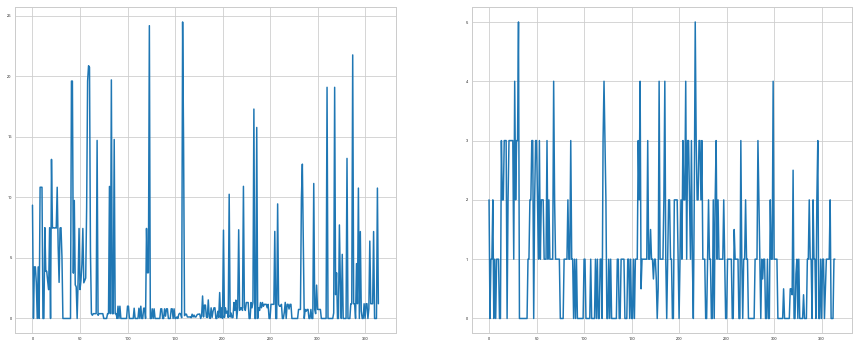

In [187]:
# 在图中绘制迁居时刻，用虚线
fig,ax = plt.subplots(1,2,figsize=(15,6))
ax[0].plot(distance)
ax[0].axvline(x=move_time_step,color='r',linestyle='--')
ax[1].plot(chain)
ax[1].axvline(x=move_time_step,color='r',linestyle='--')

C:\Users\huangnx\AppData\Local\Temp\ipykernel_27780\2967507134.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_stay['shour'] = sample_stay['stime'].apply(lambda x:x.hour)
C:\Users\huangnx\AppData\Local\Temp\ipykernel_27780\2967507134.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_stay['ehour'] = sample_stay['etime'].apply(lambda x:x.hour)
C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated

In [190]:
print(move_date)

2019-03-03 00:00:00


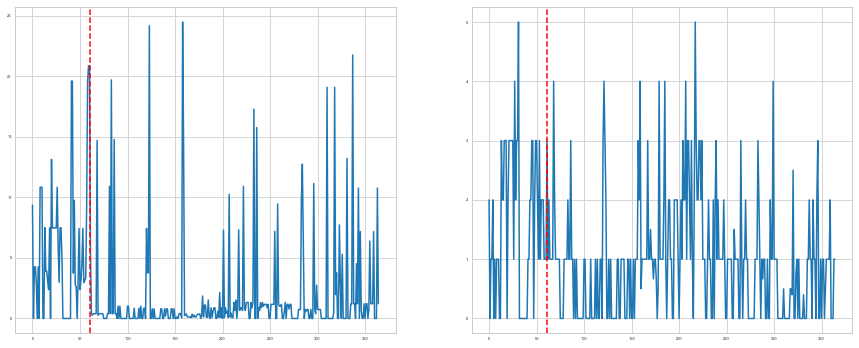

In [162]:
# 从图中或许可以推断，在迁居正式发生之前，迁居这一行为可能已经影响了人们的行为
# 找出第一次到达新家的时间点
# 构建gpd对象
poi_geometry = [Point(xy) for xy in zip(sample_stay['lambda'],sample_stay['phi'])]
sample_stay = gpd.GeoDataFrame(sample_stay,crs=crs,geometry=poi_geometry)

# 找出最早出现在new_home_area的点
new_home_area = sample_home_be.iloc[1]['area']
for index, data in sample_stay.iterrows():
    if data.loc['geometry'].within(new_home_area):
        meet_date = data.loc['date']
        break

meet_time_step = (meet_date - datetime(2019,1,1)).days

C:\Users\huangnx\AppData\Roaming\Python\Python39\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [163]:
meet_time_step
#,,,,,,失败

100

### 合并变量

In [153]:
# 先构建T, D, P三列
# T为1-365的序列
T = np.arange(1,366)
# D-干预为01序列，其中在move_time_step之前为0，之后为1
D = np.zeros(365)
D[move_time_step:] = 1
# P在move_time_step之前为0，之后为arange(1,366-move_time_step+1)
P = np.zeros(365)
P[move_time_step:] = np.arange(1,366-move_time_step)

# 构建一个dataframe
ITS_data = pd.DataFrame({'dist':distance,'chain':chain,'T':T,'D':D,'P':P})

# 使用sample_home_be构建协变量（建成环境）列，其中在move_time_step之前为group_id=0的建成环境，之后为group_id=1的建成环境
be_before = pd.concat([sample_home_be.iloc[[0]][['density','landusemix','intersections','center','subway','bus']]]*move_time_step, ignore_index=True)
be_after = pd.concat([sample_home_be.iloc[[1]][['density','landusemix','intersections','center','subway','bus']]]*(365-move_time_step), ignore_index=True)
be_repeated = pd.concat([be_before, be_after], ignore_index=True)
ITS_data[['density','landusemix','intersections','center','subway','bus']] = be_repeated

# 构建工作日控制变量
from chinese_calendar import is_workday
ITS_data['workday'] = ITS_data['T'].apply(lambda x:is_workday(datetime(2019,1,1)+timedelta(days=x-1)))
ITS_data['workday'] = ITS_data['workday'].replace({True: 1, False: 0})

In [258]:
# 对搬家前的时间点的dist_plus增加一个随机量
import random
dist_plus = [random.random() for _ in range(len(ITS_data))]
ITS_data_plus = ITS_data.copy()
ITS_data_plus['dist'] = ITS_data_plus['dist'] + dist_plus
ITS_data_plus

,dist,chain,T,D,P,density,landusemix,intersections,center,subway,bus,workday,who,date
0,0.948662,0.0,1,0.0,0.0,29.361092,0.704089,42.666667,0.000000,0.444444,10.666667,0,2078,01-Jan-19
1,0.597613,0.0,2,0.0,0.0,29.361092,0.704089,42.666667,0.000000,0.444444,10.666667,1,2078,02-Jan-19
2,0.540571,0.0,3,0.0,0.0,29.361092,0.704089,42.666667,0.000000,0.444444,10.666667,1,2078,03-Jan-19
3,0.475019,0.0,4,0.0,0.0,29.361092,0.704089,42.666667,0.000000,0.444444,10.666667,1,2078,04-Jan-19
4,0.834321,0.0,5,0.0,0.0,29.361092,0.704089,42.666667,0.000000,0.444444,10.666667,0,2078,05-Jan-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,11.482518,1.0,361,1.0,261.0,32.936153,0.637692,29.827160,5.349835,0.000000,4.148148,1,2078,27-Dec-19
361,0.581541,0.0,362,1.0,262.0,32.936153,0.637692,29.827160,5.349835,0.000000,4.148148,0,2078,28-Dec-19
362,0.500086,0.0,363,1.0,263.0,32.936153,0.637692,29.827160,5.349835,0.000000,4.148148,0,2078,29-Dec-19
363,7.636522,2.0,364,1.0,264.0,32.936153,0.637692,29.827160,5.349835,0.000000,4.148148,1,2078,30-Dec-19


## ITS分析

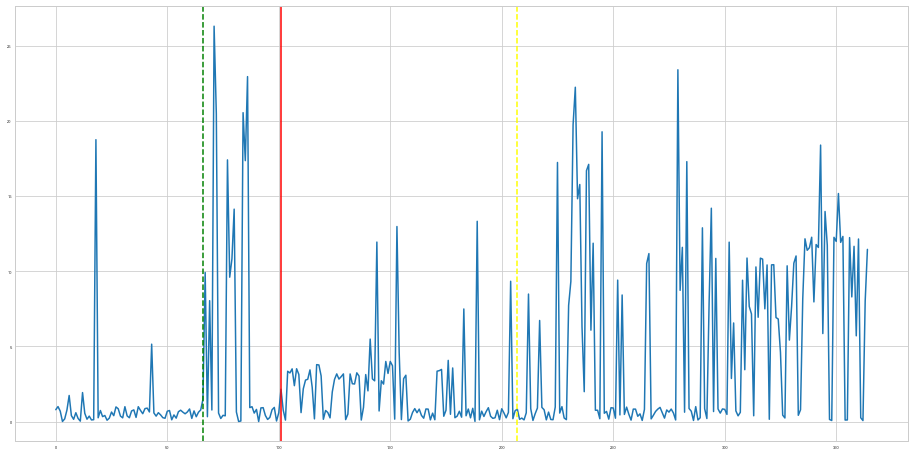

In [250]:
# 变化点检测
import ruptures as rpt
algo_before = rpt.KernelCPD(kernel="rbf", min_size=2).fit(ITS_data_plus.iloc[:101]['dist'].values)
res_before = algo_before.predict(n_bkps=1)[0]
algo_after = rpt.KernelCPD(kernel="rbf", min_size=2).fit(ITS_data_plus.iloc[101:]['dist'].values)
res_after = algo_after.predict(n_bkps=1)[0]
plt.subplots(figsize=(16,8))
plt.plot(ITS_data_plus['dist'])
plt.axvline(x=res_before,color='green',linestyle='--')
plt.axvline(x=res_after,color='yellow',linestyle='--')
plt.axvline(x=101,color='red',linestyle='-')

In [259]:
# 添加action, new_common，修改干预作用范围
action = np.zeros(365)
action[res_before:101] = 1
new_common = np.zeros(365)
new_common[res_after:] = 1
ITS_data_plus['action'] = action
ITS_data_plus['new_common'] = new_common
#ITS_data_plus.loc[res_after+1:,'D'] = 0
#ITS_data_plus.loc[res_after+1:,'P'] = 0
ITS_data_plus

,dist,chain,T,D,P,density,landusemix,intersections,center,subway,bus,workday,who,date,action,new_common
0,0.948662,0.0,1,0.0,0.0,29.361092,0.704089,42.666667,0.000000,0.444444,10.666667,0,2078,01-Jan-19,0.0,0.0
1,0.597613,0.0,2,0.0,0.0,29.361092,0.704089,42.666667,0.000000,0.444444,10.666667,1,2078,02-Jan-19,0.0,0.0
2,0.540571,0.0,3,0.0,0.0,29.361092,0.704089,42.666667,0.000000,0.444444,10.666667,1,2078,03-Jan-19,0.0,0.0
3,0.475019,0.0,4,0.0,0.0,29.361092,0.704089,42.666667,0.000000,0.444444,10.666667,1,2078,04-Jan-19,0.0,0.0
4,0.834321,0.0,5,0.0,0.0,29.361092,0.704089,42.666667,0.000000,0.444444,10.666667,0,2078,05-Jan-19,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,11.482518,1.0,361,1.0,261.0,32.936153,0.637692,29.827160,5.349835,0.000000,4.148148,1,2078,27-Dec-19,0.0,1.0
361,0.581541,0.0,362,1.0,262.0,32.936153,0.637692,29.827160,5.349835,0.000000,4.148148,0,2078,28-Dec-19,0.0,1.0
362,0.500086,0.0,363,1.0,263.0,32.936153,0.637692,29.827160,5.349835,0.000000,4.148148,0,2078,29-Dec-19,0.0,1.0
363,7.636522,2.0,364,1.0,264.0,32.936153,0.637692,29.827160,5.349835,0.000000,4.148148,1,2078,30-Dec-19,0.0,1.0


### 简单解决方案（OLS）

In [260]:
model1 = smf.ols('dist ~ T + D + P + action + new_common', data=ITS_data_plus)
res1 = model1.fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:                   dist   R-squared:                       0.165
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     14.15
Date:                Fri, 04 Aug 2023   Prob (F-statistic):           1.21e-12
Time:                        21:04:16   Log-Likelihood:                -1088.7
No. Observations:                 365   AIC:                             2189.
Df Residuals:                     359   BIC:                             2213.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9850      1.124      1.765      0.0

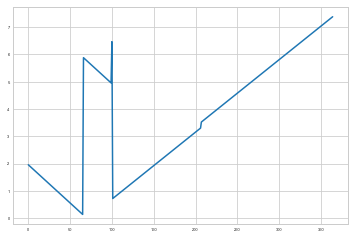

In [262]:
ITS_data_plus['y_pred'] = res1.params['T']*ITS_data_plus['T'] + res1.params['D']*ITS_data_plus['D'] + res1.params['P']*ITS_data_plus['P'] + res1.params['action']*ITS_data_plus['action'] + res1.params['new_common']*ITS_data_plus['new_common'] + res1.params['Intercept']
#plt.scatter(ITS_data_plus['T'],ITS_data_plus['dist'])
plt.plot(ITS_data_plus['y_pred'])

In [236]:
res1.ssr

8590.528954300355

C:\Users\huangnx\AppData\Local\Temp\ipykernel_27780\864442866.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Text(0, 0.5, 'distance')

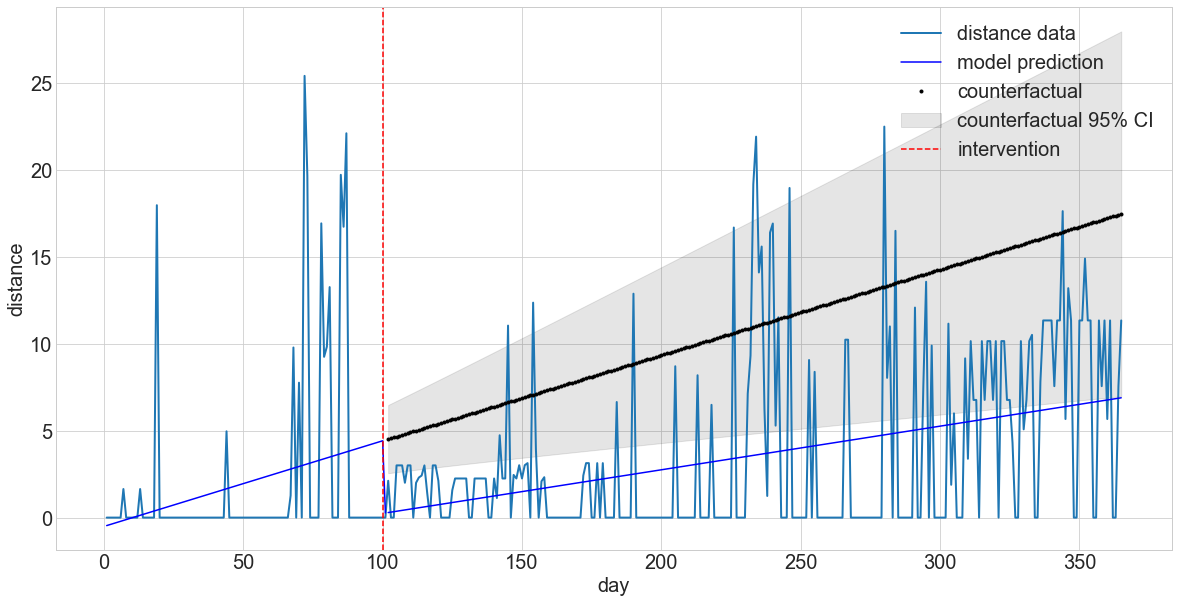

In [166]:
start = 101
end = 365
beta = res1.params

# 计算模型预测值和95%置信区间
predictions = res1.get_prediction(ITS_data)
summary = predictions.summary_frame(alpha=0.05)

# 平均预测
y_pred = predictions.predicted_mean

# 没有干预的反事实
cf_df = ITS_data.copy()
cf_df['D'] = 0.0
cf_df['P'] = 0.0

# 反事实预测
cf = res1.get_prediction(cf_df).summary_frame(alpha=0.05)

# plotting
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(figsize=(20, 10))

# plot distance data
ax.plot(ITS_data['T'], ITS_data['dist'], label='distance data', linewidth=2)

# plot model mean distance prediction
ax.plot(ITS_data['T'][:start], y_pred[:start], 'b-', label='model prediction')
ax.plot(ITS_data['T'][start:], y_pred[start:], 'b-')

# plot counterfactual mean distance with 95% confidence interval
ax.plot(ITS_data['T'][start:], cf['mean'][start:], 'k.', label='counterfactual')
ax.fill_between(ITS_data['T'][start:], cf['mean_ci_lower'][start:], cf['mean_ci_upper'][start:], color='k', alpha=0.1, label='counterfactual 95% CI')

# plot line marking intervention moment
ax.axvline(x=move_time_step, color='r', linestyle='--', label='intervention')

ax.legend(loc='best')
plt.xlabel('day')
plt.ylabel('distance')

In [173]:
# 为ITS_data增加一列全1列表示institute name
ITS_data['who'] = [2078]*365
# 构建一列日期列，其中的值为2019年1月1日加上T-1天，格式为01-Jan-19'
ITS_data['date'] = ITS_data['T'].apply(lambda x:(datetime(2019,1,1)+timedelta(days=x-1)).strftime('%d-%b-%y'))
ITS_data[['who','date','dist']].to_csv('D:/317研究组/4 居住自选择/data/sample_data/ITS_data_test.csv',header=False, index=False)

In [223]:
res1.loglikehood

AttributeError: 'OLSResults' object has no attribute 'loglikehood'